In [ ]:
# default_exp gbe.intense_sampling

## Plan 
Intense phases + two weeks before that and get alcohol consumption from sparse sampling.

# Intense data sampling

In [ ]:
def adjust_two_day_data(df, pp, date, session_column):
    two_weeks_before = date # - two weeks (TODO)
    # Set variable for two weeks before
    filtered_rows = (df.trigger_date > two_weeks_before) & (df.trigger_date < date) & (df.participant==pp)
    df.loc[filtered_rows, 'is_before_' + session_column] = True
    
    # Set variable for six weeks after
    six_weeks_after = date # + six weeks (TODO)
    filtered_rows = (df.trigger_date >= date) & (df.trigger_date < six_weeks_after) & (df.participant==pp)
    df.loc[filtered_rows, 'is_after_' + session_column] = True
    
    return df

pp_starting_date_df = starting_date_df.groupby('participant').first() # One row per participant

two_day_data['is_before_T1'] = False
two_day_data['is_before_T2'] = False
two_day_data['is_after_T1'] = False
two_day_data['is_after_T2'] = False

for row in pp_starting_date_df:
    for t in ['T1','T1']:
        two_day_data = adjust_two_day_data(two_day_data, row['participant'],row[t],t)
        two_day_data = adjust_two_day_data(two_day_data, row['participant'],row[t],t)
    
    


In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext rpy2.ipython
import seaborn as sns
from matplotlib import pyplot as plt
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", font_scale = 1.3, rc=custom_params)

In [ ]:
#export
from trr265.gbe.sst.data_provider import SSTDataProvider
import pandas as pd
import numpy as np
from scipy import stats
import biuR.wrapper

## Loading the data
In this notebook, all tests and examples are run on the initial baseline dataset.

In [ ]:
# Getting raw data
dp = SSTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_mov_data()
# Adding data from redcap
#df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
#df = df.query("is_initial and is_baseline")
#df = df.query("is_baseline")

We expect data from 16 people that already completed the intense phase two times. More people will already have started.

In [ ]:
gbe_data = df[df.FruitTap_INTENSE.isna()==False]
gbe_data = gbe_data.drop(columns='FruitTapGame')
gbe_data = gbe_data.rename(columns = {"FruitTap_INTENSE":"FruitTapGame"})
gbe_data[dp.GBE_COLUMNS] = gbe_data[dp.GBE_COLUMNS].replace({'{canceled": true}"':None})
gbe_data['session_number'] = gbe_data.groupby('participant').cumcount() + 1
gbe_data['gbe_index'] = gbe_data.participant + '_' + gbe_data.session_number.apply(lambda x: '%03d'%int(x))
gbe_data = gbe_data.set_index('gbe_index')

In [ ]:
sst = dp.decode_sst_strings(gbe_data)

In [ ]:
import trr265.gbe.sst.scoring as sst_scoring 
_df = sst_scoring.get_integration_without_replacement_ssrts(sst)

In [ ]:
gbe_data['ssrt'] = _df['ssrt_integration_without_replacement']

#### Completed SSTs per participant

<AxesSubplot:>

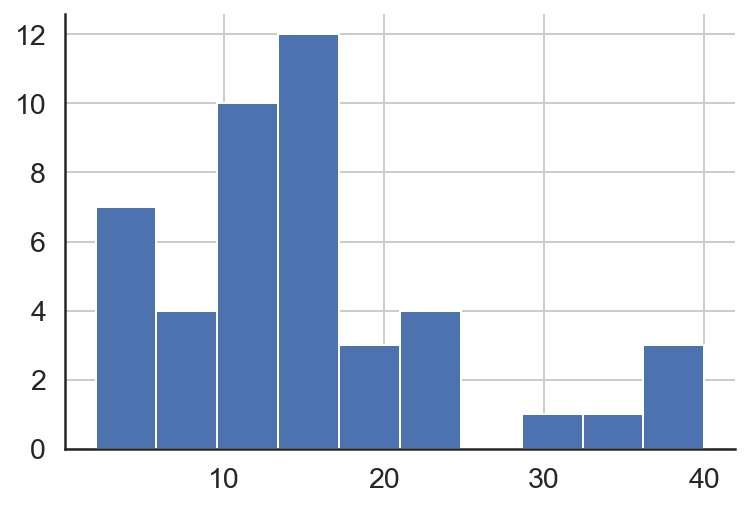

In [ ]:
gbe_data.groupby('participant').size().sort_values(ascending = False).hist()

In [ ]:
len(gbe_data.participant.unique())

45

In [ ]:
gbe_data.groupby('participant').size().describe()

count    45.000000
mean     15.200000
std       9.275089
min       2.000000
25%      10.000000
50%      14.000000
75%      18.000000
max      40.000000
dtype: float64

In [ ]:
gbe_data.groupby(['Trigger_date','ssrt']).size()

Trigger_date  ssrt      
2021-06-03    341.666667    1
2021-06-05    298.333333    1
2021-06-06    339.333333    1
2021-06-08    332.000000    1
2021-06-09    297.666667    1
                           ..
2022-03-18    255.000000    1
              341.666667    1
2022-03-20    383.333333    1
2022-03-21    369.333333    1
              376.333333    1
Length: 666, dtype: int64

SSRTs do not change with session number (simple correlation; participant structure not considered)

<AxesSubplot:xlabel='session_number', ylabel='ssrt'>

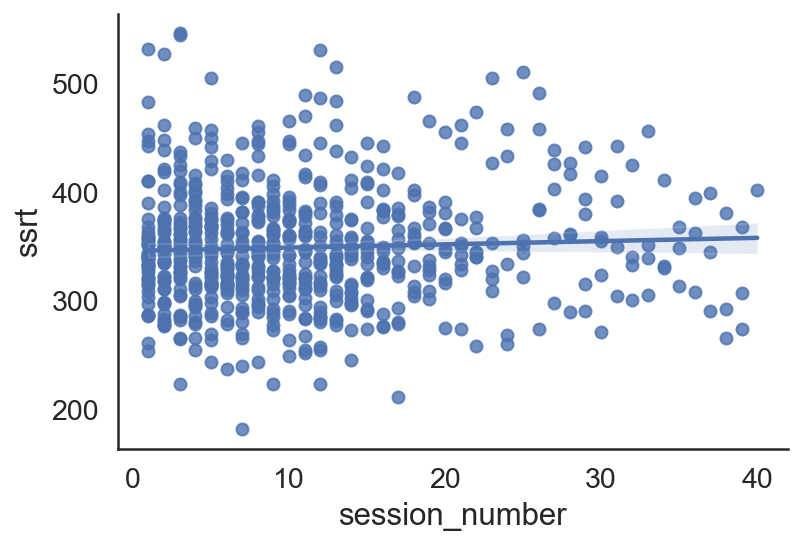

In [ ]:
import seaborn as sns
sns.regplot(x = 'session_number', y = 'ssrt', data=gbe_data)

In [ ]:
import scipy.stats

In [ ]:
correl = gbe_data[['session_number','ssrt']].dropna()

In [ ]:
scipy.stats.pearsonr(correl.session_number, correl.ssrt)

(0.047959290564516505, 0.21643232291345338)

## When did participants complete the SST?

All participants completed the SST at 8 in the morning.

In [ ]:
gbe_data.trigger_date.dt.hour.value_counts()

8    684
Name: trigger_date, dtype: int64

## Drinking data
The MorgenAbfrage asks about drinking in the last night, it is completed before the SST at 8 am. The TagesAbfrage asks about alcohol consumption another 7 pseudo random times per day between 9 am and 10 pm.

In [ ]:
#export
def get_intense_drinking_data():
    
    change_dict = {'AnzahlKleinesBier': 'kleinesBier',
 'AnzahlMittlereBier': 'mittleresBier',
 'AnzahlGrosseBier': 'grossesBier',
 'AnzahlKleinerWeisswein': 'kleinerWeisswein',
 'AnzahlMittlererWeisswein': 'mittlererWeisswein',
 'AnzahlFlascheWeisswein': 'FlascheWeisswein',
 'AnzahlKleinerRotwein': 'kleinerRotwein',
 'AnzahlMittlererRotwein': 'mittlereRotwein',
 'AnzahlFlaschenRotwein': 'FlascheRotwein',
 'AnzahlSekt': 'Sekt',
 'AnzahlFlaschenSekt': 'FlascheSekt',
 'AnzahlLikoerWein': 'Likoer-Wein',
 'AnzahlKleineLikoer': 'kleinerLikoer',
 'AnzahlGrosseLikoer': 'grosserLikoer',
 'AnzahlLikoerSuess': 'LikoerSuess',
 'AnzahlKleineSpirituosen': 'kleineSpirituosen',
 'AnzahlGrosseSpirituosen': 'grosseSpirituosen',
 'AnzahlSpirituosen100ml': 'Spirituose',
 'AnzahlSpirituosenStark': 'SpirituoseStark'}

    alc_dict = {"Anzahl"+k:v for k,v in dp.get_alcohol_per_drink().set_index('drink')['ml_alc_per_drink'].to_dict().items()}
    alc_dict_1 = dict(("INT_"+change_dict[key], value) for (key, value) in alc_dict.items())
    alc_dict_1['INT_Weinbrand'] = 7.2
    
    alc_dict_2 = dict(("INT_Morgenabfr_"+change_dict[key]+'_gesternAbend', value) for (key, value) in alc_dict.items())
    alc_dict_2['INT_Morgenabfr_Weinbrand_gesternAbend'] = 7.2
    alc_dict = {**alc_dict_1, **alc_dict_2}
    
    change_dict2 = {
'INT_Morgenabfr_kleinerLikoer_gesternAbend':'INT_Morgenabfr_Likoerklein_gesternAbend',
 'INT_Morgenabfr_kleineSpirituosen_gesternAbend':'INT_Morgenabfr_kleineSpirituose_gesternAbend',
 'INT_Morgenabfr_grosseSpirituosen_gesternAbend':'INT_Morgenabfr_grosseSpirituose_gesternAbend',
 'INT_Morgenabfr_Likoer-Wein_gesternAbend':'INT_Morgenabfr_LikoerWein_gesternAbend',
 'INT_Morgenabfr_LikoerSuess_gesternAbend':'INT_Morgenabfr_Likoersuess_gesternAbend',
 'INT_Morgenabfr_SpirituoseStark_gesternAbend':'INT_Morgenabfr_kleineSpirituoseStark_gesternAbend',
 'INT_Morgenabfr_mittlereRotwein_gesternAbend':'INT_Morgenabfr_mittlererRotwein_gesternAbend',
 'INT_Morgenabfr_grosserLikoer_gesternAbend':'INT_Morgenabfr_Likoergross_gesternAbend'}
    
    alc_dict = dict((change_dict2[key] if key in change_dict2 else key, value) for (key, value) in alc_dict.items())

    mov_data = dp.get_mov_data().reset_index()
    drinking_columns = list(alc_dict.keys())#[c for c in mov_data.columns if c.startswith("INT_")]
    two_day_columns = ['mov_index','starting_date','end_date','sampling_day'] + drinking_columns 
    # 1) Turning df into one line per date
    two_day_forms = ["Intense_Morgenabfrage","Intense_Tagesabfrage"]
    df = mov_data.sort_values(by=['participant','trigger_date','Form','Trigger_counter'])
    df = df[df.Form.isin(two_day_forms)].groupby(["participant","date"])[two_day_columns].first().dropna(how='all').reset_index()
    # 2) Turning drinking answers into dictionaries
    df[drinking_columns].fillna(0,inplace = True)
    df['drinks_heute'] = df[[c for c in drinking_columns if "gestern" not in c]].fillna(0).agg(lambda x: x.to_dict(), axis=1)
    df['drinks_gestern'] = df[[c for c in drinking_columns if "gestern" in c]].fillna(0).agg(lambda x: x.to_dict(), axis=1)
    # Adding missing values
    
    # TODO
    #def add_missing_data(df):
    #    dates = pd.date_range(df.starting_date.iloc[0]-pd.DateOffset(days = 2), df.end_date.iloc[0])
    #    df = df.reindex(dates)
    #    df.index.names = ['date']
    #    df[['starting_date','sampling_day']] = df[['starting_date','sampling_day']].bfill().ffill()
    #    return df
    #df = df.set_index('date').groupby('participant').apply(add_missing_data).drop(columns='participant').reset_index()
    
    # 3) Shifting back retrospective answers
    df['drinks_1'] = df['drinks_heute']
    df['drinks_2'] = df['drinks_gestern'].shift(-1) # Drinks yesterday shift back one days
    def combine_dicts(drinks_1, drinks_2):
        if type(drinks_2)!=dict:
            return drinks_1
        else:
            d = {**drinks_1, **drinks_2}

        
        return d
    df['drinks'] = df.apply(lambda x: combine_dicts(x.drinks_1, x.drinks_2), axis=1)

    # 4) Calculating daily alcohol consumption in grams
    #alc_dict = {"Anzahl"+k:v for k,v in self.get_alcohol_per_drink().set_index('drink')['ml_alc_per_drink'].to_dict().items()}
    def calculate_g_alc(x):
        if x != x:
            ml_alc = np.nan
        else:
            ml_alc = 0
            for k,v in x.items():
                if v > 0:
                    ml_alc += alc_dict[k]*v#.split('_')[0]] * v
        return ml_alc * .8
    df['g_alc']  = df.drinks.apply(calculate_g_alc)
    # Returning relevant columns only
    df = df.reset_index()
    df['sampling_day'] = df.groupby('participant').starting_date.cumcount() + 1
    df.index.rename('intense_index',inplace = True)
    return df[['mov_index','participant','starting_date','date','sampling_day','g_alc']]
_df = get_intense_drinking_data()

In [ ]:
_df['g_alc'].describe()

count    2489.000000
mean       25.425842
std        38.761349
min         0.000000
25%         0.000000
50%         9.200000
75%        39.600000
max       482.400000
Name: g_alc, dtype: float64

In [ ]:
_df

,mov_index,participant,starting_date,date,sampling_day,g_alc
intense_index,,,,,,
0,187371,m004,2020-05-04,2021-04-12,1,0.0
1,187374,m004,2020-05-04,2021-04-13,2,0.0
2,187385,m004,2020-05-04,2021-04-14,3,0.0
3,187397,m004,2020-05-04,2021-04-15,4,0.0
4,187406,m004,2020-05-04,2021-04-16,5,0.0
...,...,...,...,...,...,...
2484,355894,m297,2021-07-12,2022-02-26,39,0.0
2485,355915,m297,2021-07-12,2022-02-27,40,0.0
2486,355919,m297,2021-07-12,2022-02-28,41,0.0


In [ ]:
pd.to_datetime(gbe_data.date.iloc[0])

Timestamp('2021-07-01 00:00:00')

In [ ]:
pd.

In [ ]:
_df.date.iloc[0].strftime('%Y-%m-%d')

'2021-04-12'

In [ ]:
_df.date.isna().mean()

0.0

In [ ]:
gbe_data['date'] = gbe_data['Form_start_date']
#df1 = gbe_data.set_index(['participant','date'])
_df['date2'] = _df.date.apply(lambda x: x.strftime('%Y-%m-%d'))
#df2 = _df.set_index(['participant','date'])


In [ ]:
gbe_data.date.iloc[0]

'2021-07-01'

In [ ]:
_df.date2.iloc[2]

'2021-04-14'

In [ ]:
merged = gbe_data.merge(_df, left_on = ['participant','date'], right_on = ['participant','date2'])

<AxesSubplot:xlabel='ssrt', ylabel='g_alc'>

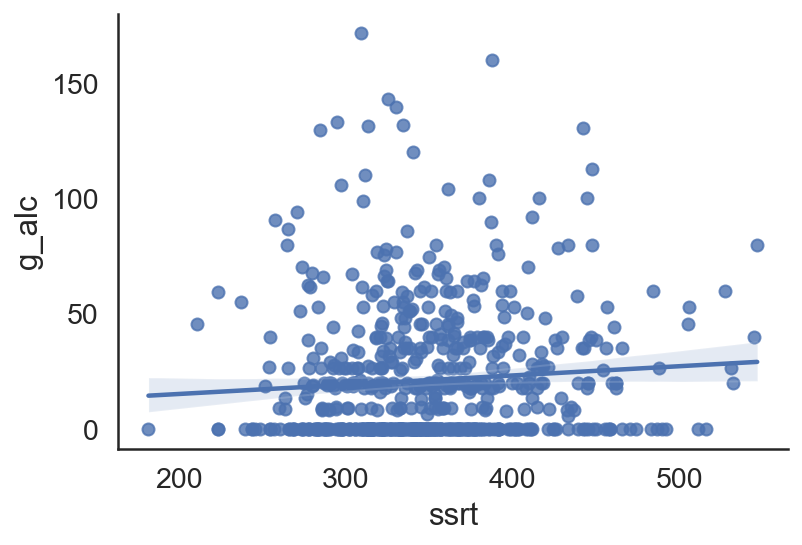

In [ ]:
sns.regplot(x = 'ssrt', y = 'g_alc', data = merged)

In [ ]:
r_data = merged[['participant','ssrt','g_alc']].dropna()

In [ ]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr


spearmanr(r_data['ssrt'], r_data['g_alc'])

SpearmanrResult(correlation=0.10846051864394643, pvalue=0.00507789891853012)

In [ ]:
%%R -i r_data
require(lmerTest)
m = lmer(g_alc ~ ssrt + (1+ ssrt|participant), data = r_data)
summary(m)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: g_alc ~ ssrt + (1 + ssrt | participant)
   Data: r_data

REML criterion at convergence: 6287.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6969 -0.6085 -0.2593  0.3485  5.2445 

Random effects:
 Groups      Name        Variance  Std.Dev.  Corr
 participant (Intercept) 9.396e+01  9.693359     
             ssrt        6.884e-05  0.008297 0.35
 Residual                6.796e+02 26.069043     
Number of obs: 666, groups:  participant, 45

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)
(Intercept)  13.84498    8.50910 437.28298   1.627    0.104
ssrt          0.01764    0.02397 179.90087   0.736    0.463

Correlation of Fixed Effects:
     (Intr)
ssrt -0.972
optimizer (nloptwrap) convergence code: 0 (OK)
Model failed to converge with max|grad| = 4.77229 (tol = 0.002, component 1)
Model is nearly unidentifiable: very large eigenvalue
 - Rescale variab

In [ ]:
gbe_data.query('participant=="m297"').Form_start_date

gbe_index
m297_001    2022-01-18
m297_002    2022-01-19
m297_003    2022-01-21
m297_004    2022-01-22
m297_005    2022-01-23
m297_006    2022-01-24
m297_007    2022-01-28
m297_008    2022-02-05
m297_009    2022-02-24
m297_010    2022-02-25
m297_011    2022-02-26
m297_012    2022-02-28
m297_013    2022-03-01
m297_014    2022-03-02
Name: Form_start_date, dtype: object

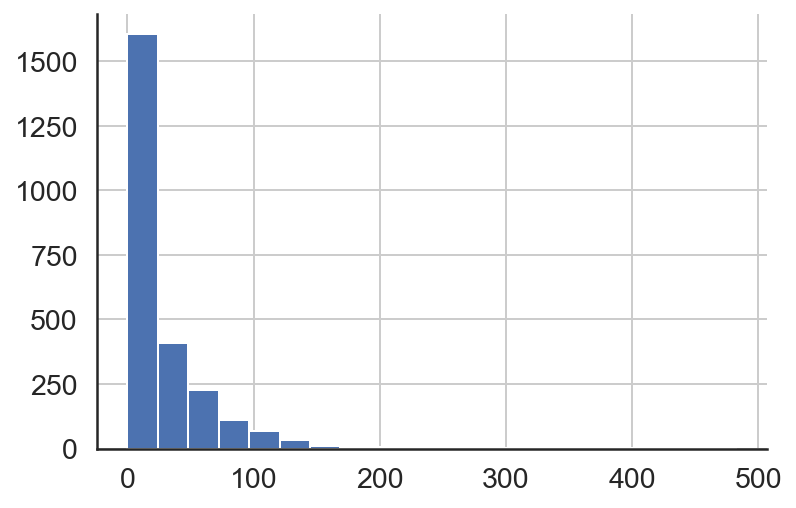

In [ ]:
_df.g_alc.hist(bins = 20)
sns.despine()

In [ ]:
_df.INT_Coverage_kleinesBier.isna().mean()

1.0

In [ ]:
INT_Coverage_kleineSpirituose
INT_Coverage_kleineSprirituose

## Fluctuations in SSRTs

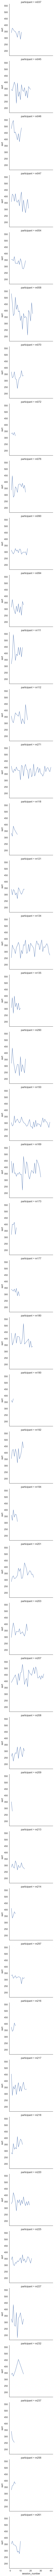

In [ ]:
sns.relplot(x = "session_number", y = "ssrt", kind = 'line', row = "participant", data = gbe_data) # Add hue when you have alcohol data.

1.0

In [ ]:
list(df.filter(like='INT_').columns)

['INT_Morgenabfr_MDBF_zufrieden',
 'INT_Morgenabfr_MDBF_unruhig',
 'INT_Morgenabfr_MDBF_unwohl',
 'INT_Morgenabfr_MDBF_entspannt',
 'INT_Morgenabfr_MDBF_energiegeladen',
 'INT_Morgenabfr_MDBF_muede',
 'INT_Morgenabfr_PANAS_aengstlich',
 'INT_Morgenabfr_PANAS_gereizt',
 'INT_Morgenabfr_PANAS_einsam',
 'INT_Morgenabfr_PANAS_schuldig',
 'INT_Morgenabfr_aktueller_Alkoholkonsum',
 'INT_Morgenabfr_liking',
 'INT_Morgenabfr_wanting',
 'INT_Morgenabfr_aversive_effects',
 'INT_Morgenabfr_craving',
 'INT_Morgenabfr_Getraenke_1',
 'INT_Morgenabfr_Getraenke_2',
 'INT_Morgenabfr_Getraenke_3',
 'INT_Morgenabfr_Getraenke_4',
 'INT_Morgenabfr_Getraenke_5',
 'INT_Morgenabfr_Getraenke_6',
 'INT_Morgenabfr_Getraenke_7',
 'INT_Morgenabfr_Getraenke_8',
 'INT_Morgenabfr_Getraenke_9',
 'INT_Morgenabfr_Getraenke_10',
 'INT_Morgenabfr_Getraenke_11',
 'INT_Morgenabfr_Getraenke_12',
 'INT_Morgenabfr_Getraenke_13',
 'INT_Morgenabfr_Getraenke_14',
 'INT_Morgenabfr_Getraenke_15',
 'INT_Morgenabfr_Getraenke_16',
 'I